In [55]:
# more common imports
import pandas as pd
import numpy as np
from collections import Counter
import re
import os

# languange processing imports
import nltk
from gensim.corpora import Dictionary
# preprocessing imports
from sklearn.preprocessing import LabelEncoder

# model imports
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.word2vec import Word2Vec
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
# hyperparameter training imports
from sklearn.model_selection import GridSearchCV

# visualization imports
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import io
%matplotlib inline
sns.set()  # defines the style of the plots to be seaborn style

# Abre os dados

In [56]:
#Verifica os dados no diretorio

Data = os.listdir("../../Filter/Tweets_Filtered/")
for i in range(len(Data)):
    Data[i] = Data[i].split(".")[0]
    
Pessoas = ["realDonaldTrump", "jairbolsonaro", "hbredda", "gui_benchimol", "pedrocerize"]

NoticiasPolitica = ["OGloboPolitica", "folha_poder", "GloboNews", "EstadaoPolitica", 
                    "RevistaEpoca", "valoreconomico", "g1politica", "conexaopolitica", "EstadaoEconomia", 
                    "UOLEconomia", "folha_mercado", "g1economia", "OGlobo_Economia"]

Noticias = ["UOL", "folha", "g1", "VEJA", "cartacapital", "RevistaISTOE"]


Alvo = NoticiasPolitica

#Monta um Dataframe com todos datasets de twites de todas as pessoas
AllData = pd.DataFrame()
for i in Alvo:
    if i in Data:
        MoreData = pd.read_csv("../../Filter/Tweets_Filtered/{0}".format(i+".csv"), sep=";", decimal=",", encoding='utf-16')
        AllData = pd.concat([AllData, MoreData])
    else:
        print("{0} não disponivel".format(i))
        
AllData = AllData.reset_index(drop=True)

In [57]:
#Adiciona um Id para cada pessoa
label_encoder = LabelEncoder()

label_encoder.fit(AllData.Pessoa)
AllData['Pessoa_id'] = label_encoder.transform(AllData.Pessoa)

In [58]:
AllData.sample(5)

,Pessoa,Data,Texto,Retweets,Likes,URL,Pessoa_id
30440,UOLEconomia,2019-02-12 15:57:36,união não precisa mais ressarcir estados por l...,0,5,1,6
22623,conexaopolitica,2019-04-13 18:44:25,mundo ong de direitos humanos critica condenaç...,163,1040,1,7
9356,GloboNews,2019-02-08 15:17:36,dez pessoas morreram e três ficaram feridas no...,35,342,1,2
23000,conexaopolitica,2019-03-21 15:43:21,urgente moreira franco é preso veja o momento ...,2675,10333,1,7
13769,RevistaEpoca,2019-02-02 23:11:52,durante esse segundo pleito renan calheiros pe...,0,3,1,5


In [59]:
#Mede o comprimento medio dos tweets
document_lengths = np.array(list(map(len, AllData.Texto.str.split(' '))))

print("The average number of words in a document is: {}.".format(np.mean(document_lengths)))
print("The minimum number of words in a document is: {}.".format(min(document_lengths)))
print("The maximum number of words in a document is: {}.".format(max(document_lengths)))

The average number of words in a document is: 13.991752676762806.
The minimum number of words in a document is: 2.
The maximum number of words in a document is: 30.


In [60]:
#Remove os Tweets com compriento menor que 4 palavras
smallerthen4 = document_lengths <= 5

for i in range(len(document_lengths)):
    if smallerthen4[i]:
        AllData = AllData.drop(i)

document_lengths = np.array(list(map(len, AllData.Texto.str.split(' '))))

AllData = AllData.reset_index(drop=True)

In [61]:
#Baixa alguns modulos do NLKT

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\edufe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\edufe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\edufe\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [62]:
# Transforma o documento em sentenças
def Data_Tokenizer(df):
    """ All the preprocessing steps for word2vec are done in this function.
    All mutations are done on the dataframe itself. So this function returns
    nothing.
    """
    df['document_sentences'] = df.Texto.str.split('.')  # split texts into individual sentences
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(map(nltk.word_tokenize, sentences)),
                                         df.document_sentences))  # tokenize sentences
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(sentences),
                                         df.tokenized_sentences))  # remove unwanted characters
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(filter(lambda lst: lst, sentences)),
                                         df.tokenized_sentences))  # remove empty lists

Data_Tokenizer(AllData)

In [63]:
def lda_get_good_tokens(df):
    df['tokenized_text'] = list(map(nltk.word_tokenize, df.Texto))
    df['tokenized_text'] = list(df.tokenized_text)

lda_get_good_tokens(AllData)

In [64]:
print(nltk.corpus.stopwords.words('portuguese')[0:20])

['de', 'a', 'o', 'que', 'e', 'do', 'da', 'em', 'um', 'para', 'com', 'não', 'uma', 'os', 'no', 'se', 'na', 'por', 'mais', 'as']


In [65]:
def remove_stopwords(df):
    """ Removes stopwords based on a known set of stopwords
    available in the nltk package. In addition, we include our
    made up word in here.
    """
    # Luckily nltk already has a set of stopwords that we can remove from the texts.
    stopwords = nltk.corpus.stopwords.words('portuguese')[0:20]
    
    del(stopwords[stopwords.index("não")])
    ManualStop = ["istoégente", "expressoepoca", "globonews", "estudioi", "rt", "andreiasadi",
                  "’", "‘", "”", "“", "r", ",", ".", "…", "diz", "à", "ao"]
    Numbers = list(range(10))
    stopwords = stopwords + ManualStop + Numbers
    
    df['stopwords_removed'] = list(map(lambda doc:
                                       [word for word in doc if word not in stopwords],
                                       df['tokenized_text']))

remove_stopwords(AllData)

In [66]:
dictionary = Dictionary(documents=AllData.stopwords_removed.values)

print("Found {} words.".format(len(dictionary.values())))

dictionary.filter_extremes(no_above=0.8, no_below=3)

dictionary.compactify()  # Reindexes the remaining words after filtering
print("Left with {} words after filtering".format(len(dictionary.values())))

Found 29532 words.
Left with 12050 words after filtering


In [67]:
def document_to_bow(df):
    df['bow'] = list(map(lambda doc: dictionary.doc2bow(doc), df.stopwords_removed))
    
document_to_bow(AllData)

In [68]:
def lda_preprocessing(df):
    """ All the preprocessing steps for LDA are combined in this function.
    All mutations are done on the dataframe itself. So this function returns
    nothing.
    """
    lda_get_good_tokens(df)
    remove_stopwords(df)
    document_to_bow(df)

In [69]:
AllData.sample(5)

,Pessoa,Data,Texto,Retweets,Likes,URL,Pessoa_id,document_sentences,tokenized_sentences,tokenized_text,stopwords_removed,bow
28697,UOLEconomia,2019-04-12 07:03:43,estique seu salário para não acabar antes do f...,0,4,1,6,[estique seu salário para não acabar antes do ...,"[[estique, seu, salário, para, não, acabar, an...","[estique, seu, salário, para, não, acabar, ant...","[estique, seu, salário, não, acabar, antes, fi...","[(24, 1), (70, 1), (313, 1), (412, 1), (899, 1..."
22676,conexaopolitica,2019-03-25 14:11:47,mundo romênia vai transferir embaixada para je...,467,2155,1,7,[mundo romênia vai transferir embaixada para j...,"[[mundo, romênia, vai, transferir, embaixada, ...","[mundo, romênia, vai, transferir, embaixada, p...","[mundo, romênia, vai, transferir, embaixada, j...","[(202, 1), (1385, 1), (1996, 1), (4730, 1), (5..."
4142,folha_poder,2019-02-26 05:10:02,cerco da receita a ministros do supremo e do s...,8,12,1,9,[cerco da receita a ministros do supremo e do ...,"[[cerco, da, receita, a, ministros, do, suprem...","[cerco, da, receita, a, ministros, do, supremo...","[cerco, receita, ministros, supremo, stj, faz,...","[(28, 1), (135, 1), (213, 1), (381, 1), (613, ..."
28931,UOLEconomia,2019-04-02 20:53:36,líder do psl cobra que bolsonaro seja garoto p...,2,7,1,6,[líder do psl cobra que bolsonaro seja garoto ...,"[[líder, do, psl, cobra, que, bolsonaro, seja,...","[líder, do, psl, cobra, que, bolsonaro, seja, ...","[líder, psl, cobra, bolsonaro, seja, garoto, p...","[(61, 1), (93, 1), (156, 1), (557, 1), (638, 1..."
28941,UOLEconomia,2019-04-02 16:41:40,equipe econômica estuda reduzir impostos sobre...,0,19,1,6,[equipe econômica estuda reduzir impostos sobr...,"[[equipe, econômica, estuda, reduzir, impostos...","[equipe, econômica, estuda, reduzir, impostos,...","[equipe, econômica, estuda, reduzir, impostos,...","[(27, 1), (61, 1), (111, 1), (2379, 1), (3220,..."


In [88]:
import datetime

DateInterval = [datetime.datetime.strptime("17:00:00", "%H:%M:%S").time(), 
                datetime.datetime.strptime("9:00:00", "%H:%M:%S").time()]

oneday = datetime.timedelta(days=1)
daytweets = []
tweets_data = {}

datas = AllData['Data']
tweets = AllData['bow']
likes = AllData['Likes']
retweets = AllData['Retweets']
Started = True
lastday = datetime.datetime.strptime(datas[0], '%Y-%m-%d %H:%M:%S').date()

for j in range (0, len(datas)):

    data = datetime.datetime.strptime(datas[j], '%Y-%m-%d %H:%M:%S').date()
    time = datetime.datetime.strptime(datas[j], '%Y-%m-%d %H:%M:%S').time()

    if data != lastday:
        delta = abs(int(str(data - lastday).split(" ")[0]))
        if int(delta) >= 2:
            #Acaba o periodo por força bruta
            Started = False
            if(str(data) not in tweets_data):
                tweets_data[str(data)] = daytweets
            else:
                for k in daytweets:
                    tweets_data[str(data+oneday)].append(k)
            daytweets = []

    #Test to 00:00
    First = (DateInterval[0] < time) and (time < datetime.datetime.strptime("23:59:59", "%H:%M:%S").time())
    #Test from 00:00
    Second = (datetime.datetime.strptime("00:00:01", "%H:%M:%S").time() < time) and (time < DateInterval[1])

    if First or Second:
        Started = True
        #Esta dentro do periodo
        daytweets.append(tweets[j])

    elif Started:
        #Acaba o periodo
        Started = False
        if(str(data+oneday) not in tweets_data):
            tweets_data[str(data+oneday)] = daytweets
        else:
            for k in daytweets:
                tweets_data[str(data+oneday)].append(k)
        daytweets = []

    lastday = data

Dates = list(tweets_data.keys())

for i in range(3):
    print(Dates[i], tweets_data[Dates[i]][0:2])

2019-04-25 [[(104, 1), (1203, 1), (1258, 1), (1295, 1), (1568, 1), (1569, 1), (3532, 1), (3965, 1), (4223, 1), (4651, 1), (6160, 1), (6902, 1), (8383, 1), (9433, 1)], [(28, 1), (445, 1), (446, 1), (789, 1), (815, 1), (1022, 1), (1110, 1), (1979, 1), (3620, 1), (3796, 1), (9893, 1)]]
2019-04-24 [[(21, 1), (22, 1), (28, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1)], [(22, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1)]]
2019-04-23 [[(50, 1), (83, 1), (90, 1), (192, 1), (193, 1), (194, 1), (195, 1), (196, 1)], [(22, 1), (24, 1), (27, 1), (28, 1), (74, 1), (166, 1), (197, 1), (198, 1)]]


# Análise de tópicos

In [71]:
#Selecioan os dados que serão suados na LDA
corpus = AllData.bow

In [72]:
num_topics = 10
#Treina a LDA com o multicore do gensim
LDAmodel = LdaMulticore(corpus=corpus,
                        id2word=dictionary,
                        num_topics=num_topics,
                        workers=11,
                        chunksize=10000,
                        iterations = 5,
                        passes=7,
                        alpha='asymmetric')

In [73]:
def document_to_lda_features(lda_model, document):
    """ Transforms a bag of words document to features.
    It returns the proportion of how much each topic was
    present in the document.
    """
    topic_importances = LDAmodel.get_document_topics(document, minimum_probability=0)
    topic_importances = np.array(topic_importances)
    return topic_importances[:,1]

AllData['lda_features'] = list(map(lambda doc:
                              document_to_lda_features(LDAmodel, doc),
                              AllData.bow))

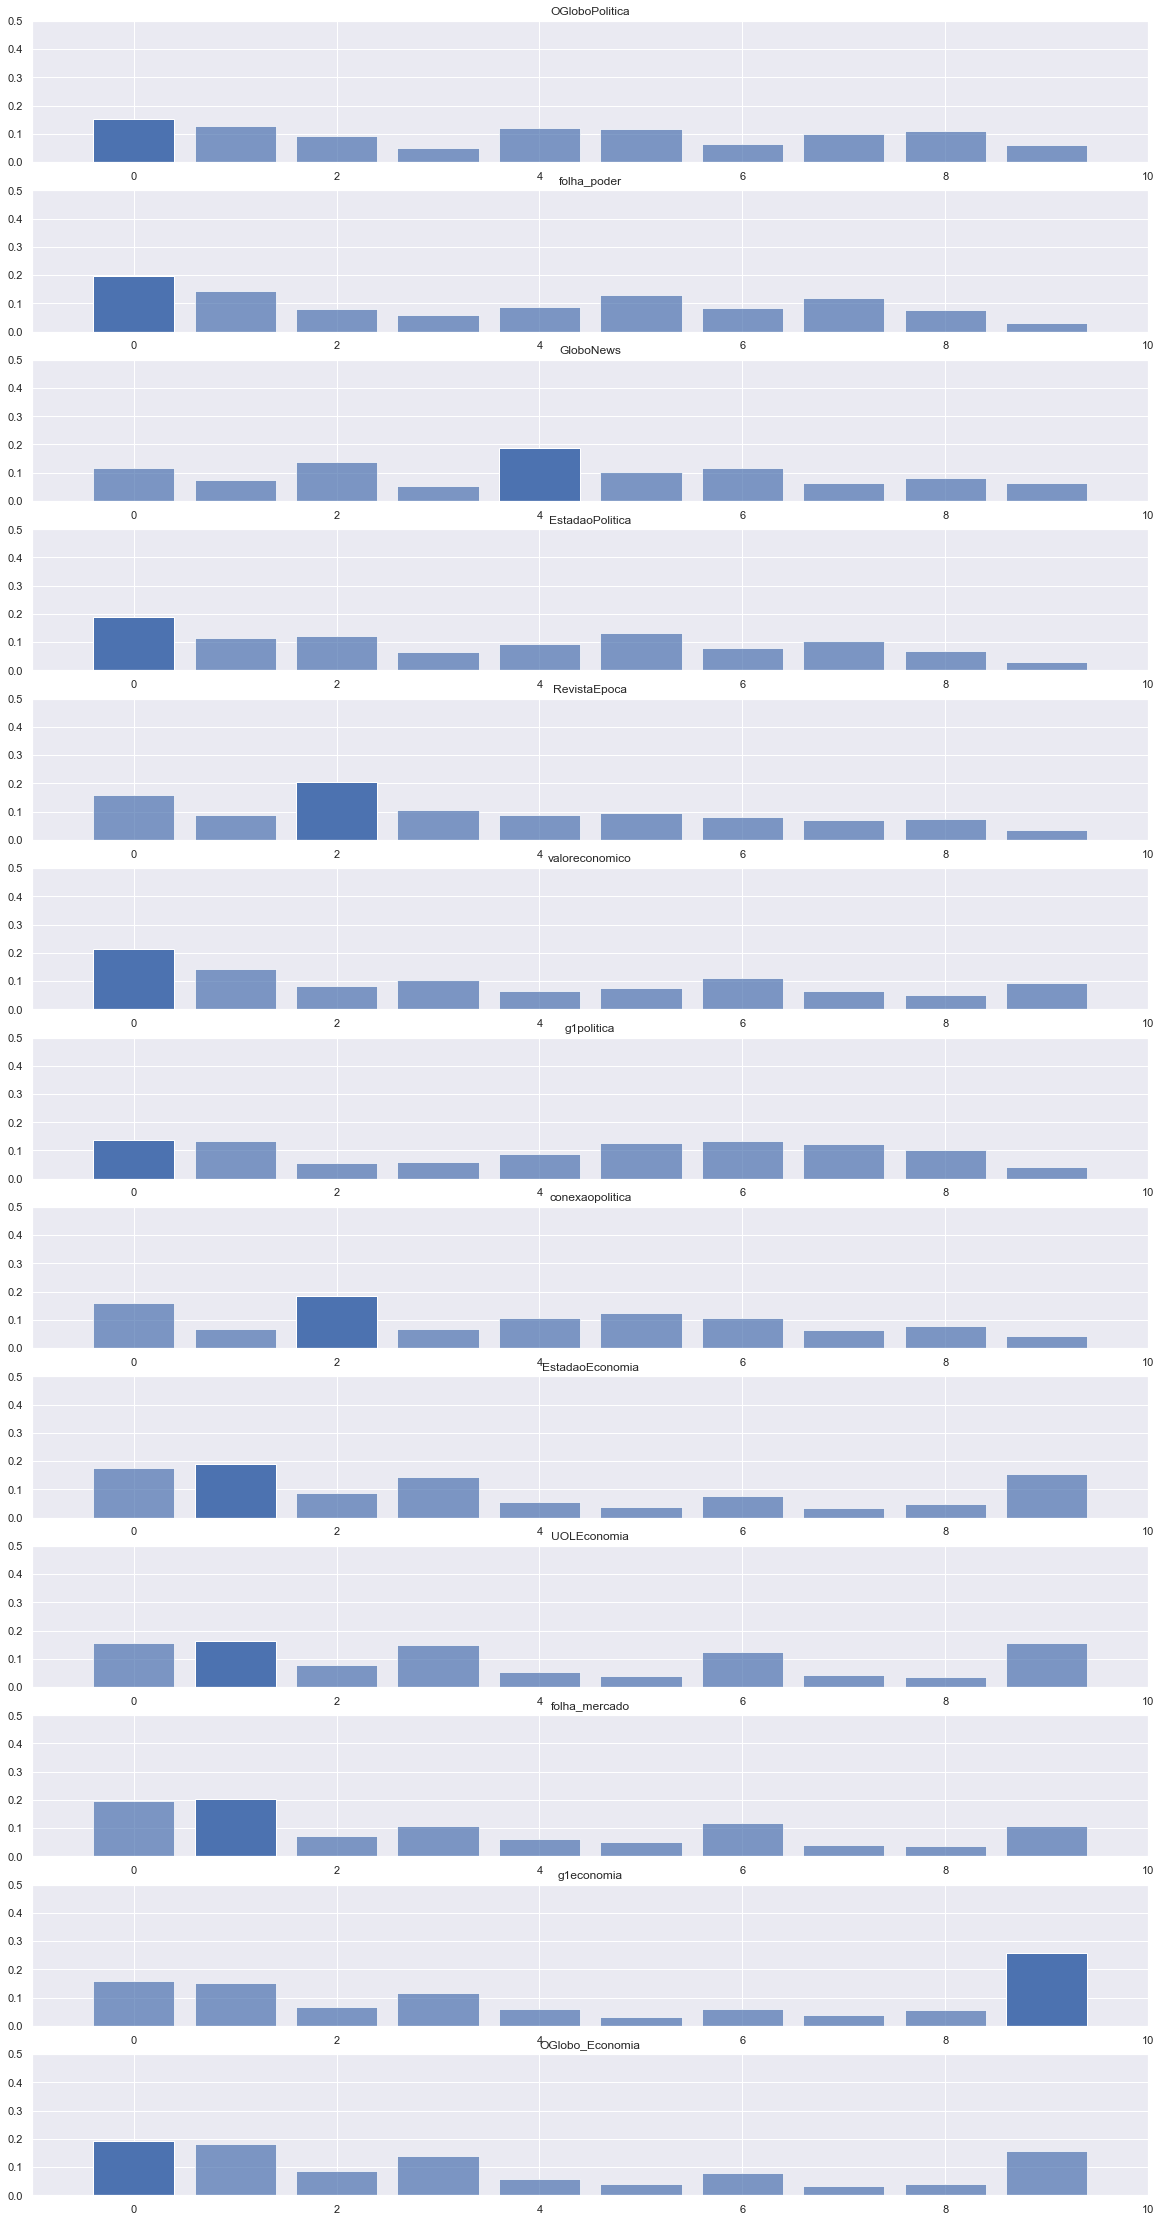

In [74]:
#Cria histogramas com a distribuição dos Topicos

topic_distribution = []
for i in Alvo:
    topic_distribution.append(AllData.loc[AllData.Pessoa == i, 'lda_features'].mean())
    
ax = 0

Axes = [ax]*len(Alvo)
fig, Axes = plt.subplots(len(Alvo),figsize=(20,40))

nr_top_bars = 1

for i in range(len(Axes)):
    Axes[i].set_title(Alvo[i])

for ax, distribution in zip(Axes, topic_distribution):
    # Individual distribution barplots
    ax.bar(range(len(distribution)), distribution, alpha=0.7)
    rects = ax.patches
    for i in np.argsort(distribution)[-nr_top_bars:]:
        rects[i].set_alpha(1)
    # General plotting adjustments
    ax.set_xlim(-1, num_topics)
    ax.set_ylim(0,0.5)

In [75]:
AllData.sample(5)

,Pessoa,Data,Texto,Retweets,Likes,URL,Pessoa_id,document_sentences,tokenized_sentences,tokenized_text,stopwords_removed,bow,lda_features
1094,OGloboPolitica,2019-02-20 17:44:29,davi alcolumbre tenta acelerar votação de proj...,14,41,1,3,[davi alcolumbre tenta acelerar votação de pro...,"[[davi, alcolumbre, tenta, acelerar, votação, ...","[davi, alcolumbre, tenta, acelerar, votação, d...","[davi, alcolumbre, tenta, acelerar, votação, p...","[(167, 1), (262, 1), (264, 1), (476, 1), (1425...","[0.051089830696582794, 0.015512831509113312, 0..."
3873,folha_poder,2019-03-15 15:03:02,conheça as atribuições da assembleia de sp e q...,2,1,1,9,[conheça as atribuições da assembleia de sp e ...,"[[conheça, as, atribuições, da, assembleia, de...","[conheça, as, atribuições, da, assembleia, de,...","[conheça, atribuições, assembleia, sp, quais, ...","[(132, 1), (376, 1), (550, 1), (681, 1), (961,...","[0.021727103739976883, 0.01896800473332405, 0...."
36240,g1economia,2019-03-19 12:08:24,dólar opera em queda nesta terça feira,0,8,1,10,[dólar opera em queda nesta terça feira ],"[[dólar, opera, em, queda, nesta, terça, feira]]","[dólar, opera, em, queda, nesta, terça, feira]","[dólar, opera, queda, nesta, terça, feira]","[(198, 1), (199, 1), (201, 1), (1142, 1), (780...","[0.029161302372813225, 0.022103657945990562, 0..."
19295,g1politica,2019-04-03 00:04:13,engenheiros poderão ficar em silêncio na cpi d...,5,12,1,11,[engenheiros poderão ficar em silêncio na cpi ...,"[[engenheiros, poderão, ficar, em, silêncio, n...","[engenheiros, poderão, ficar, em, silêncio, na...","[engenheiros, poderão, ficar, silêncio, cpi, b...","[(56, 1), (210, 1), (496, 1), (607, 1), (1019,...","[0.023197567090392113, 0.07021066546440125, 0...."
20057,g1politica,2019-02-26 20:18:13,defesa de lula pede ao stf para suspender ação...,4,8,1,11,[defesa de lula pede ao stf para suspender açã...,"[[defesa, de, lula, pede, ao, stf, para, suspe...","[defesa, de, lula, pede, ao, stf, para, suspen...","[defesa, lula, pede, stf, suspender, ação, pen...","[(22, 1), (27, 1), (126, 1), (133, 1), (166, 1...","[0.020613480359315872, 0.015522358939051628, 0..."


In [76]:
#Cria uma função para pegar as TopWors dos topicos
def get_topic_top_words(lda_model, topic_id, nr_top_words=5):
    """ Returns the top words for topic_id from lda_model."""
    id_tuples = lda_model.get_topic_terms(topic_id, topn=nr_top_words)
    word_ids = np.array(id_tuples)[:,0]
    words = map(lambda id_: lda_model.id2word[id_], word_ids)
    return words

In [77]:
from pprint import pprint

print("Looking up top words from top topics")
for x in range(num_topics):
    top_words = get_topic_top_words(LDAmodel, x, nr_top_words=50)
    pprint(f"For topic {x+1}, the top words are:")
    pprint("{0}".format(", ".join(top_words)))
    pprint("")
print("")

Looking up top words from top topics
'For topic 1, the top words are:'
('bolsonaro, é, governo, dos, não, ministro, presidente, sobre, brasil, mundo, '
 'tem, como, ano, após, jairbolsonaro, novo, eua, petrobras, economia, ser, '
 'sp, 2018, são, estadão, últimas, crise, vai, venezuela, mercado, nas, foi, '
 'será, sem, ex, país, onyx, moro, trump, política, quer, está, ministério, '
 'empresas, casa, educação, mas, já, milhões, rio, trimestre')
''
'For topic 2, the top words are:'
('vai, contra, governo, bolsonaro, é, paulo, dos, são, sobre, tem, brasil, '
 'das, justiça, ministro, nova, após, não, stf, china, sp, eua, temer, como, '
 'crédito, lava, empresas, jato, mil, entre, dados, deve, fim, anuncia, até, '
 'estadão, previdência, dodge, milhões, entenda, pagar, abre, câmara, país, '
 'setor, pode, mantém, regras, reforma, terá, quer')
''
'For topic 3, the top words are:'
('é, rio, nos, não, bolsonaro, pt, coluna, governo, presidente, sobre, anos, '
 'política, como, pode, janeiro

In [78]:
TopicsData = np.array(list(AllData["lda_features"]))
TopicsData = np.transpose(TopicsData)

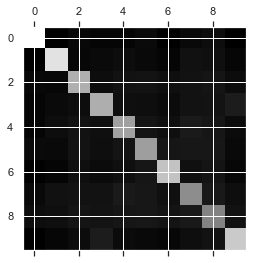

In [79]:
CovMatrix = np.cov(TopicsData)
plt.matshow(CovMatrix, cmap=plt.cm.gray)
plt.show()

In [80]:
len(AllData)

41073

## Filtra as ações

In [81]:
Stocks = ["ibov", "ITUB4", "PETR4", "Vale3", "BBDC4", "ABEV3", "BBAS3", "SANB3", "LREN3"]

Cols = {}
for i in range(len(Stocks)):
    Cols[Stocks[i]] = [i*4+i, i*4+i+1, i*4+i+2, i*4+i+3]

In [82]:
Var = 'PETR4'
bolsa = pd.read_excel('../../Dados_Bolsa/Twt.xlsx', sheet_name="1h", usecols=Cols[Var],  skiprow=[0])

In [83]:
headers = list(bolsa.keys())
myheaders = [Var, "Price", "Volume", "Ticks"]

for i in range(len(headers)):
    bolsa.rename(columns={headers[i]: myheaders[i]}, inplace=True)
    
bolsa = bolsa.dropna()
bolsa.drop(bolsa.head(1).index,inplace=True)

bolsa = bolsa.reset_index(drop=True)

In [84]:
bolsa.head(5)

,PETR4,Price,Volume,Ticks
0,2018-10-09 10:00:00,26.53,16993100,16015
1,2018-10-09 11:00:00,26.69,17752300,13529
2,2018-10-09 12:00:00,26.79,7840900,9768
3,2018-10-09 13:00:00,26.83,8244300,9649
4,2018-10-09 14:00:00,26.84,7674700,8604


In [85]:
ibov_len  = len(bolsa[Var])
ibov_len

1099

In [86]:
import datetime

ibov_data_precos = {}
DeadZoneUp = 0.3e-2
DeadZoneDown = 0.6e-2
# célula para identificar os preços de abertura e fechamento de cada dia
for i in range(0, ibov_len):
    data_completa = datetime.datetime.strptime(str(bolsa[Var][i]), '%Y-%m-%d %H:%M:%S')
    preco = bolsa['Price'][i]
    data = data_completa.strftime("%Y-%m-%d")
    if data not in ibov_data_precos:
        ibov_data_precos[data] = {}
        ibov_data_precos[data]['abertura'] = preco
        #caso só tenhamos informação de uma hora dentro de um dia, assumimos esse preco como o de fechamento tbm
        ibov_data_precos[data]['fechamento'] = preco 
        dia_anterior_completo =  data_completa - datetime.timedelta(days=1)
        dia_anterior_data = dia_anterior_completo.strftime("%Y-%m-%d")
        
        if(dia_anterior_data in ibov_data_precos):
            dia_anterior_fechamento = ibov_data_precos[dia_anterior_data]['fechamento']
            
            if(preco > dia_anterior_fechamento + dia_anterior_fechamento*DeadZoneUp):
                ibov_data_precos[data]['variacao'] = 2 #Subiu
            elif (preco < dia_anterior_fechamento - dia_anterior_fechamento*DeadZoneDown):
                ibov_data_precos[data]['variacao'] = 0 #Desceu
            else:
                ibov_data_precos[data]['variacao'] = 1
        else:
            #se não tivermos informações sobre o dia anterior, assumimos que a variacao foi neutra
            ibov_data_precos[data]['variacao'] = 0 
    else:
        if i < (ibov_len - 1):
            data_seguinte = datetime.datetime.strptime(str(bolsa[Var][i+1]), '%Y-%m-%d %H:%M:%S')
            if data_seguinte.date() > data_completa.date():
                ibov_data_precos[data]['fechamento'] = preco

Datesibov = list(ibov_data_precos.keys())
                
for i in range(4):
    print(Datesibov[i], ibov_data_precos[Datesibov[i]])

2018-10-09 {'abertura': 26.53, 'fechamento': 26.82, 'variacao': 0}
2018-10-10 {'abertura': 25.87, 'fechamento': 26.05, 'variacao': 0}
2018-10-11 {'abertura': 26.35, 'fechamento': 25.29, 'variacao': 2}
2018-10-15 {'abertura': 25.68, 'fechamento': 25.77, 'variacao': 0}


## Cria os Datasets

In [146]:
lastdays = [0, 0, 0, 0, 0]
lastday = 0
InputData = []
OutputData = []
for data in ibov_data_precos:
    if(data in tweets_data):
        #Utiliza modelos para gerar os dados
        Result = []
        for document in tweets_data[data]:
            ThisTopic = (LDAmodel.get_document_topics(document, minimum_probability=0))
            Result.append([])
            for i in ThisTopic:
                Result[-1].append(i[1])
        
        Mean = []
        ResultT = np.transpose(Result)
        for Res in ResultT:
            Mean.append(np.mean(Res))

        Covariance = np.cov(ResultT)
        
        #Faz uma lista dos resultados dos ultimos 5 dias
        lastdays.append(lastday)
        del(lastdays[0])
        
        #Salva os topicos + covariancias no x
        datex = (list(Mean) + list(Covariance.flatten()) + list(lastdays))
        InputData.append(datex)
        OutputData.append(ibov_data_precos[data]['variacao'])
        
        #Lembra coisad do ultimo dia
        lastday = ibov_data_precos[data]['variacao']

In [147]:
len(OutputData), len(InputData), len(InputData[0])

(127, 127, 115)

In [ ]:
from sklearn.model_selection import train_test_split

train_texts, test_texts, train_classes, test_classes = train_test_split(InputData, OutputData, 
                                                                        test_size=0.2, stratify=OutputData)

## Distribuição das Classes:

In [148]:
trainlen = len(OutputData)

print(OutputData.count(0)/trainlen)
print(OutputData.count(1)/trainlen)
print(OutputData.count(2)/trainlen)
print()

0.41732283464566927
0.2440944881889764
0.33858267716535434



## Aplicação de Modelos

In [149]:
from sklearn.model_selection import cross_val_predict, cross_val_score

### Regressão Logistica

In [150]:
from sklearn.linear_model import LogisticRegression

Losgisticclf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')

scores = cross_val_score(Losgisticclf, InputData, OutputData, cv=3, n_jobs=-1)

print(scores)
print(np.mean(scores))

[0.31818182 0.47619048 0.31707317]
0.3704818217013339


### Decision Tree

In [151]:
from sklearn import tree

tree = tree.DecisionTreeClassifier()

scores = cross_val_score(tree, InputData, OutputData, cv=3, n_jobs=-1)

print(scores)
print(np.mean(scores))

[0.38636364 0.4047619  0.36585366]
0.38565973322070884


### Randon Forest

In [152]:
from sklearn.ensemble import RandomForestClassifier

RandonForestclf = RandomForestClassifier(n_estimators=10, n_jobs=-1)

scores = cross_val_score(RandonForestclf, InputData, OutputData, cv=3, n_jobs=-1)

print(scores)
print(np.mean(scores))

[0.40909091 0.33333333 0.43902439]
0.3938162108893816


In [153]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [10, 30, 100], 
    'min_impurity_decrease': [1e-5, 1e-6, 0]}
  ]

RandonForestclf = RandomForestClassifier(n_estimators=10, min_impurity_decrease=1e-3)

grid_search = GridSearchCV(RandonForestclf, param_grid, cv=5, scoring='accuracy', return_train_score=True, n_jobs=-1)

grid_search.fit(InputData, OutputData)

print(grid_search.best_params_, grid_search.best_score_)

BestParams = grid_search.best_params_

RandonForestclf = RandomForestClassifier(n_estimators=BestParams["n_estimators"], 
                                         min_impurity_decrease=BestParams["min_impurity_decrease"])

{'min_impurity_decrease': 1e-06, 'n_estimators': 100} 0.4409448818897638


C:\Users\edufe\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


## Best Model

In [154]:
TopClassifier = RandonForestclf

y_pred = cross_val_predict(TopClassifier, InputData, OutputData, cv=3)

In [155]:
Output_Pred = list(y_pred)

print("Resultado Modelo:")
print(Output_Pred.count(0)/len(Output_Pred))
print(Output_Pred.count(1)/len(Output_Pred))
print(Output_Pred.count(2)/len(Output_Pred))

Resultado Modelo:
0.6062992125984252
0.14960629921259844
0.2440944881889764


In [156]:
from sklearn.metrics import confusion_matrix

conf_mx = confusion_matrix(OutputData, Output_Pred)
conf_mx

array([[33,  8, 12],
       [19,  5,  7],
       [25,  6, 12]], dtype=int64)

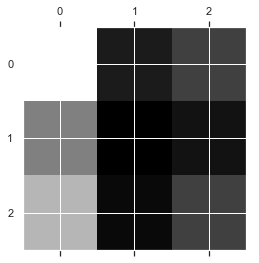

In [157]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [158]:
InputDataa = np.array(InputData)
OutputDataa = np.array(OutputData)
Output_Preda = np.array(Output_Pred)

In [159]:
AllResults = pd.DataFrame(InputData)
AllResults["Output"]= OutputDataa
AllResults["Output_pred"]= Output_Preda

AllResults.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,107,108,109,110,111,112,113,114,Output,Output_pred
94,0.225717,0.095857,0.106910,0.119848,0.132217,0.059520,0.054052,0.047392,0.060808,0.097681,...,-0.000536,-0.000002,0.036200,0,2,2,2,1,0,2
76,0.133251,0.138302,0.075331,0.077080,0.134249,0.106243,0.107739,0.078150,0.072949,0.076707,...,-0.004192,-0.002269,0.028655,2,2,1,0,1,0,2
103,0.173417,0.123566,0.089836,0.088696,0.082706,0.066376,0.139024,0.081047,0.061569,0.093763,...,-0.001856,-0.003910,0.043475,1,2,1,1,0,1,1
48,0.140796,0.205600,0.110572,0.103736,0.050928,0.076749,0.049678,0.107939,0.064315,0.089688,...,-0.004741,-0.004256,0.042205,1,0,0,2,0,1,0
78,0.157492,0.163113,0.117388,0.068874,0.120264,0.052442,0.099254,0.085744,0.070093,0.065337,...,-0.003842,-0.001874,0.023985,1,0,1,0,2,0,1


In [161]:
ResultCorr = np.array(AllResults.corr())

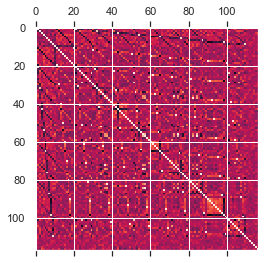

In [162]:
plt.matshow(ResultCorr)
plt.show()

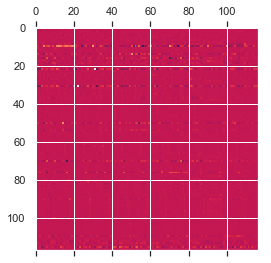

In [163]:
row_sums = ResultCorr.sum(axis=1, keepdims=True)
norm_corr = ResultCorr / row_sums
np.fill_diagonal(norm_corr, 0.005)

plt.matshow(norm_corr)
plt.show()